In [225]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import root_mean_squared_error

In [226]:
df = pd.read_csv('data/salaries.csv')

sal_cap = 300000
df = df[df['salary_in_usd'] <= sal_cap]

df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
88578,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L
88580,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
88581,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
88582,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [227]:
df = df.drop(columns=['salary'])
df = pd.get_dummies(df, columns=['work_year', 'experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size'])

print(f'df has {len(df.columns)} columns')
df

df has 234 columns


,job_title,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,work_year_2025,experience_level_EN,experience_level_EX,...,company_location_UA,company_location_US,company_location_VE,company_location_VN,company_location_XK,company_location_ZA,company_location_ZM,company_size_L,company_size_M,company_size_S
0,Customer Success Manager,60000,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,Engineer,165000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
2,Engineer,109000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
3,Applied Scientist,294000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
4,Applied Scientist,137600,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88578,Data Specialist,165000,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
88580,Principal Data Scientist,151000,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
88581,Data Scientist,105000,True,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
88582,Business Data Analyst,100000,True,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False


In [228]:
# find single and bigram keywords

job_title_keywords = set()

for job_title in df['job_title']:
    keyword_list = job_title.strip().lower().split(' ')

    for i in range(len(keyword_list) - 1):
        job_title_keywords.add(keyword_list[i])
        job_title_keywords.add(f'{keyword_list[i]} {keyword_list[i+1]}')

    job_title_keywords.add(keyword_list[-1])
    

print(job_title_keywords)
print(len(job_title_keywords))

{'biologist', 'site reliability', 'strategy lead', 'technology integrator', 'account', 'chatbot', 'intelligence engineer', 'nlp', 'learning manager', 'member', 'technical writer', 'integrator', 'data devops', 'visualization developer', 'reliability', 'postdoctoral', 'intelligence data', 'robotics software', 'representative', 'analytics manager', 'learning performance', 'management lead', 'java', 'algorithm developer', 'integration coordinator', 'developer', 'fellow', 'data operator', 'performance', 'data analysis', 'ai solution', 'product specialist', 'prompt engineer', 'people data', 'business intelligence', 'ai product', 'backend', 'software architect', 'controls engineer', 'finance data', 'programmer', 'management associate', 'safety', 'learning research', 'power bi', 'learning', 'etl', 'sales data', 'databricks engineer', 'research analyst', 'insights manager', 'deep', 'principal data', 'computational', 'bi architect', 'data pipeline', 'insight analyst', 'product owner', 'and', 'le

In [229]:
df_synthetic = df.copy()

df_synthetic['job_title_lower'] = df_synthetic['job_title'].str.lower()

new_cols = {}

for keyword in job_title_keywords:
    col_name = f'keyword_{keyword}'
    new_col = df_synthetic['job_title_lower'].str.contains(rf'\b{keyword}\b', regex=True)
    if sum(new_col) >= 100:
        new_cols[col_name] = new_col

df_synthetic = pd.concat([df_synthetic, pd.DataFrame(new_cols)], axis=1)

df_synthetic = df_synthetic.drop(columns=['job_title_lower', 'job_title'])
df = df.drop(columns=['job_title'])

print(f'df_synthetic has {len(df_synthetic.columns)} columns')
df_synthetic

df_synthetic has 359 columns


,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,work_year_2025,experience_level_EN,experience_level_EX,experience_level_MI,...,keyword_full,keyword_consultant,keyword_machine learning,keyword_research,keyword_research engineer,keyword_owner,keyword_applied scientist,keyword_of,keyword_modeler,keyword_data modeler
0,60000,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,165000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,109000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,294000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,137600,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88578,165000,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
88580,151000,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
88581,105000,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
88582,100000,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Root Mean Squared Error: 53051.92
Coefficients: [2161.2320332012105, -2570.3331602307117, -6374.424702335164, -612.4562643759054, 5615.571385703394, 1780.4107080385802, -42904.35215566115, 36034.396218858135, -10132.073830497644, 17002.02976730452, -259.9147006476951, -4487.303824670191, 21340.251079507943, -16593.032554188077, -9494.984284959028, -5346.669165637279, 2557.078486094033, -9909.629267943375, 6557.41540907426, -56330.21608128009, 34122.94420571824, -13717.308000673223, -38721.61404677663, -3617.3556516726344, 3827.2660905452763, 54623.3594044253, -9317.117743203216, -5728.026620118597, 25067.304919767277, 13706.830660747282, 68022.25590197644, 16556.930076944744, -2738.131412323877, 3.54702933691442e-11, -41650.100970399675, 2905.355159033282, -20249.084349383116, -5225.423829458602, 32020.47801596545, -37921.55690645649, 5457.16187275447, -9683.807498749717, -101666.75299053088, -34848.43595629866, -6004.345034473012, -217.84608222598763, 35164.09465521241, -1079.07107096

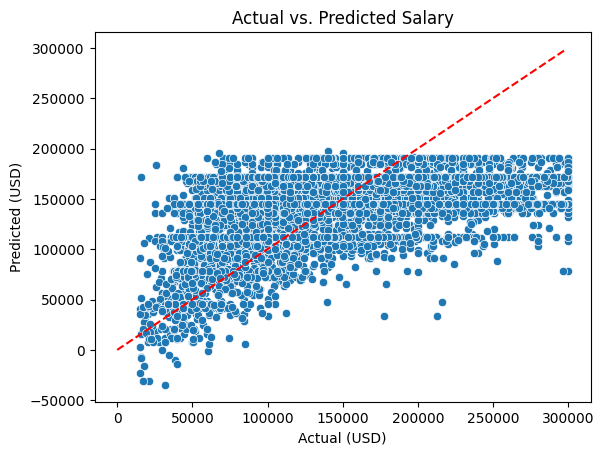

In [230]:
prediction_col = 'salary_in_usd'

X = df.drop(columns=[prediction_col])
y = df[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

Root Mean Squared Error: 48925.93
Coefficients: [2024.4835537540228, -3573.1893072113126, -2932.724670669053, 1199.8939491509982, 2402.8568566063, 878.6796183721492, -29037.17418791145, 32297.39281840755, -13688.895949539685, 10428.67731904512, -48.69775590889731, 320.7060737335851, 15551.368745209864, -15823.377063032962, -8623.34022731171, -9781.366092058452, 2489.797101874121, 11096.420459819477, 4507.267983786609, -63818.239059861604, 34417.413306095885, -15199.983056263938, -26120.090968843222, -3457.9896553477665, 15673.926563408135, 20745.376250376354, -5072.095262628227, -23662.300094203874, -2027.9727203357506, 21753.023004036324, 85773.515764031, 13500.769703164231, -2984.68339482346, -3.2741809263825417e-11, -11399.083857111376, 18093.656375370614, -25916.386863550673, -10616.937801092912, 33248.9811424411, -52619.678600974745, 13494.252176494116, -17334.178016905513, -66838.74152837161, -13631.542857761191, 826.7542104895025, 2367.2975929388367, 48888.60527895614, -2149.654

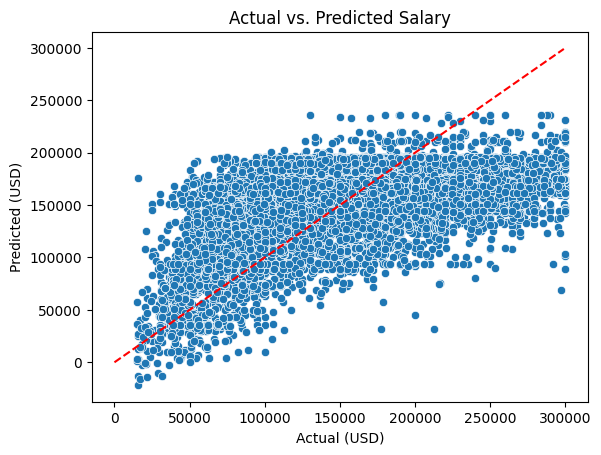

In [231]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

In [232]:
selector = SelectKBest(score_func=f_regression, k=20)
X_new = selector.fit_transform(X, y)

# Get selected column names
selected_columns = X.columns[selector.get_support()]

Root Mean Squared Error: 50935.40
experience_level_EN      -63420.36
experience_level_MI      -48583.66
experience_level_SE      -22392.01
salary_currency_EUR      -10956.47
salary_currency_GBP      -21309.11
salary_currency_USD      42447.63
employee_residence_GB    21741.76
employee_residence_US    41359.80
company_location_GB      7453.54
company_location_US      -14728.40
keyword_learning         -12137.06
keyword_engineer         -1380.12
keyword_machine          -81828.82
keyword_data analyst     7752.41
keyword_software         -6869.21
keyword_software engineer 23751.74
keyword_data             -12817.76
keyword_learning engineer 32810.59
keyword_analyst          -36983.42
keyword_machine learning 82336.59
Intercept: 127713.56533311102


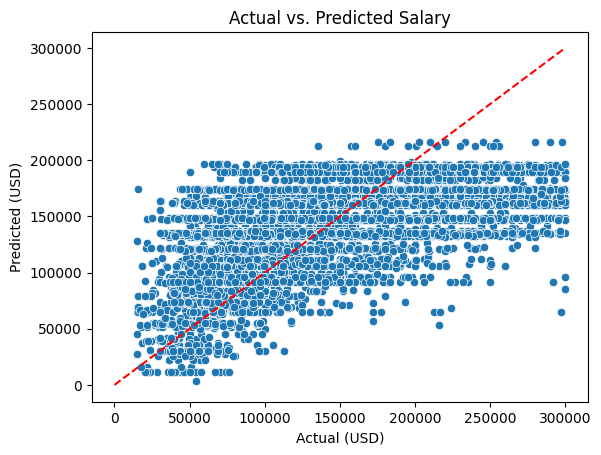

In [233]:
prediction_col = 'salary_in_usd'

X = df_synthetic[selected_columns]
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
for i in range(len(selected_columns)):
    print(f"{selected_columns[i].ljust(24)} {model.coef_.tolist()[i]:.2f}")
#print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

Root Mean Squared Error: 49368.93


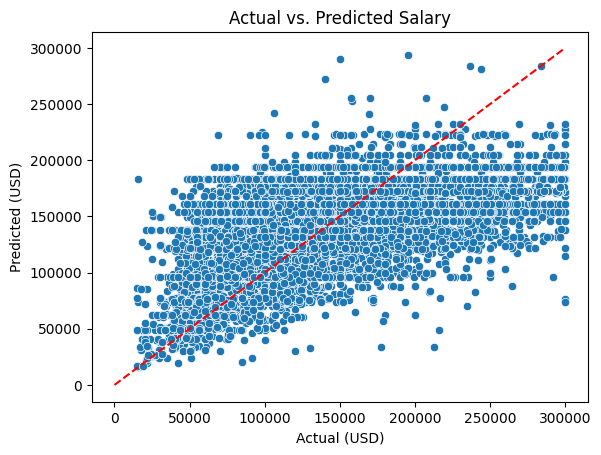

In [ ]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = DecisionTreeRegressor(criterion='absolute_error')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()